In [67]:
import pandas as pd
pd.set_option('max_colwidth', 70)
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import requests
import random
import numpy as np
import seaborn as sns

In [68]:
# Define State
def fetch_pool_data(pool_id= "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640", UNISWAP_V3_SUBGRAPH_URL = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3'):
    # Fetching liquidity positions
    liquidity_query = """
    {
      positions(where: { pool: "%s" }) {
        liquidity
        tickLower {
          price0
        }
        tickUpper {
          price0
        }
      }
    }
    """ % pool_id
    liquidity_data = requests.post(UNISWAP_V3_SUBGRAPH_URL, json={'query': liquidity_query}).json()

    # Fetching pool price, volume, fees, and reserves
    pool_query = """
    {
      pools(where: { id: "%s" }) {
        token0Price
        token1Price
        volumeUSD
        feesUSD
        totalValueLockedToken0
        totalValueLockedToken1
      }
    }
    """ % pool_id
    pool_data = requests.post(UNISWAP_V3_SUBGRAPH_URL, json={'query': pool_query}).json()

    # Fetching swaps and trades
    swaps_query = """
    {
      swaps(where: { pool: "%s" }, first: 10, orderBy: timestamp, orderDirection: desc) {
        amount0
        amount1
        amountUSD
        timestamp
      }
    }
    """ % pool_id
    swaps_data = requests.post(UNISWAP_V3_SUBGRAPH_URL, json={'query': swaps_query}).json()

        # Constructing the state representation with float data type
    state = {
        'liquidity_ranges': [(float(position['tickLower']['price0']), float(position['tickUpper']['price0']), float(position['liquidity'])) for position in liquidity_data['data']['positions'] if float(position['liquidity']) != 0.0],
        'pool_price': float(pool_data['data']['pools'][0]['token0Price']),
        'volumeUSD': float(pool_data['data']['pools'][0]['volumeUSD']),
        'feesUSD': float(pool_data['data']['pools'][0]['feesUSD']),
        'reserves': {
            'token0': float(pool_data['data']['pools'][0]['totalValueLockedToken0']),
            'token1': float(pool_data['data']['pools'][0]['totalValueLockedToken1'])
        },
        'recent_swaps': [(float(swap['amount0']), float(swap['amount1']), float(swap['amountUSD'])) for swap in swaps_data['data']['swaps']]
    }

    return state

pool_state = fetch_pool_data()
pool_state

{'liquidity_ranges': [(414675923.600571,
   415506063.80495846,
   746755412055405.0),
  (409729795.93603504, 410550034.4818099, 1147770206691903.0),
  (404438044.080679, 406058954.8732922, 424633036024159.0),
  (391701534.41554964, 428159465.1361321, 25754023399426.0),
  (391701534.41554964, 428159465.1361321, 24834292629283.0),
  (391701534.41554964, 428159465.1361321, 26203807977410.0),
  (277693324.8742835, 285578217.1102181, 194408905116698.0)],
 'pool_price': 1668.282381991908,
 'volumeUSD': 393385815855.0416,
 'feesUSD': 196692907.9275208,
 'reserves': {'token0': 183974296.406949, 'token1': 141890.14003224982},
 'recent_swaps': [(19000.0, -11.38213632886502, 19011.088812809965),
  (1508.094512, -0.9034245195798424, 1508.9627299610179),
  (-75247.965451, 45.124997115372494, 75331.12687151448),
  (-79129.11639, 47.44831038332461, 79212.7068644651),
  (-85721.553108, 51.39480651045397, 85806.64570935376),
  (-8000.0, 4.796106260049247, 8007.660810190075),
  (1500.0, -0.898375383740

In [ ]:
python3 -m pip install cython
sudo apt update
sudo apt install python3-pip
python3 -m pip install cython
python3 -m pip install --user cython
python3 -m pip install cytoolz
python3 -m pip install eth-brownie



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1000, 2, 5, 7)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 2, 5, 7)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 7.70s


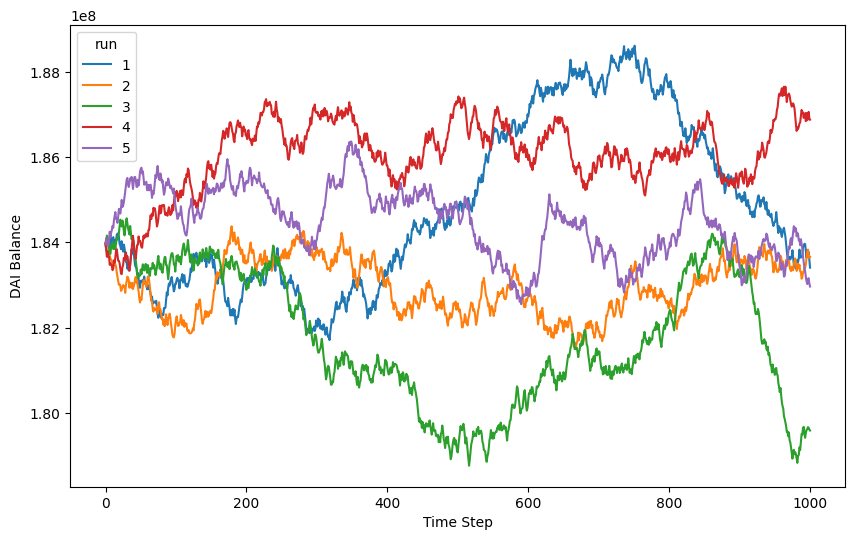

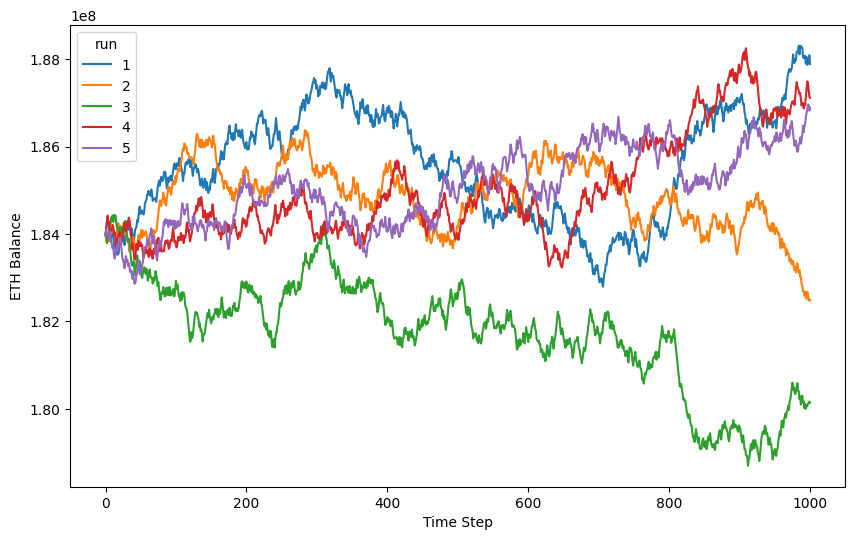

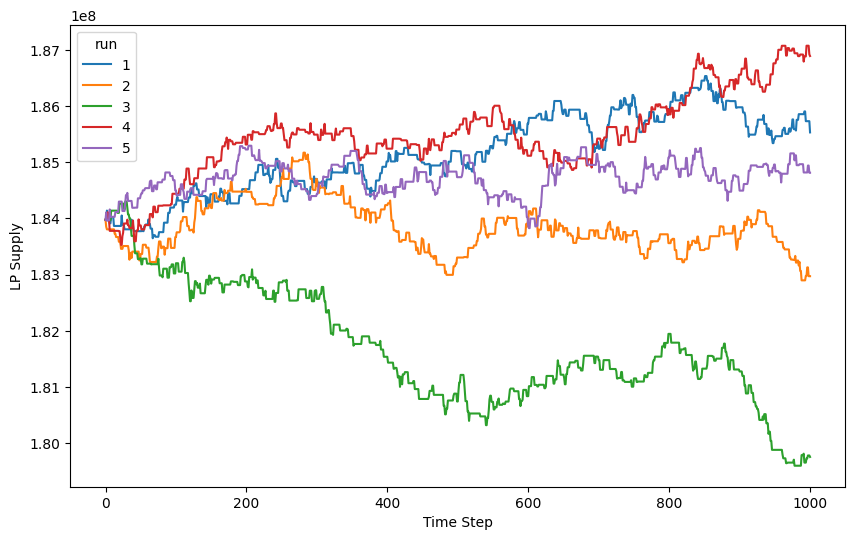

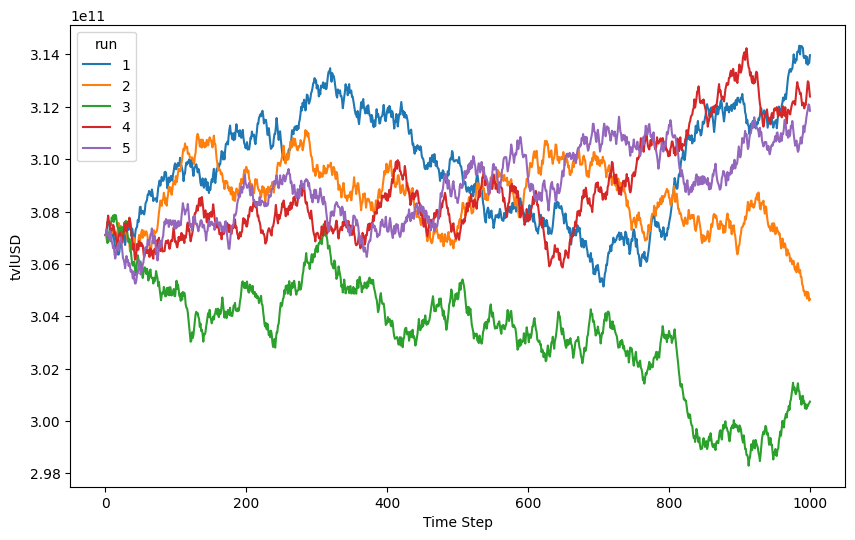

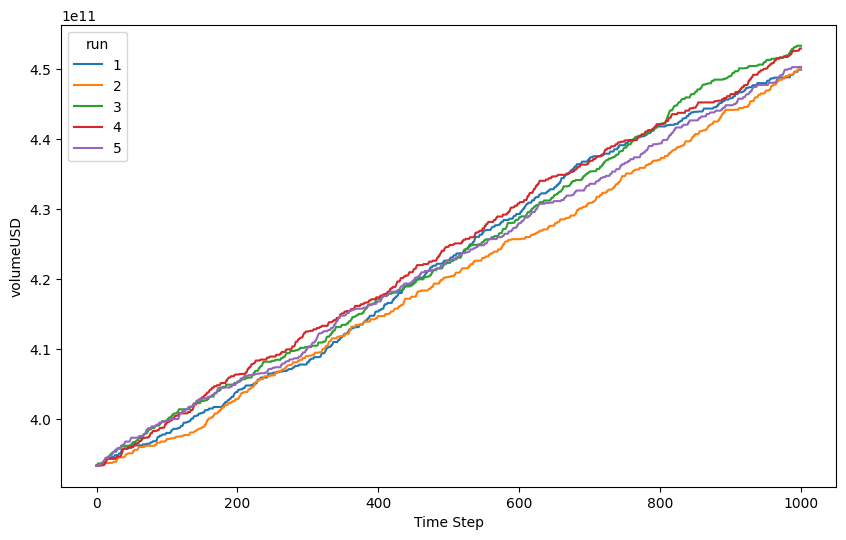

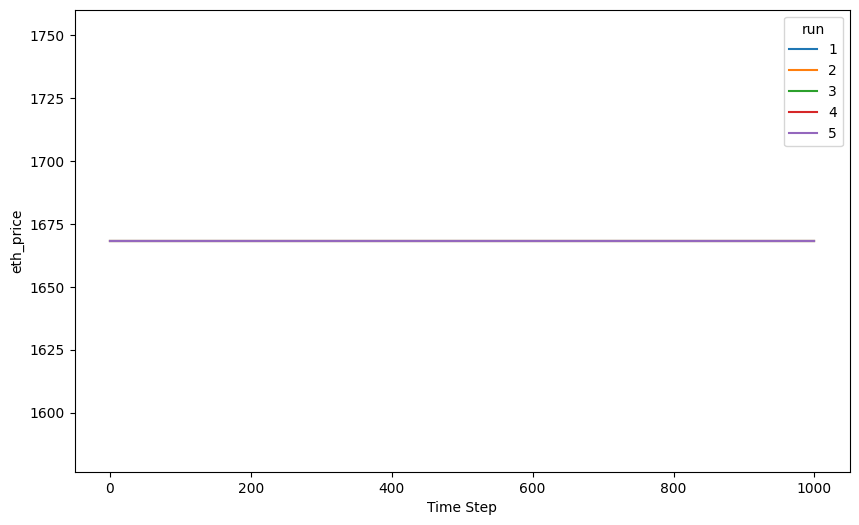

In [69]:
TIMESTEPS=1000
RUNS=5

state = {
    'DAI_balance': pool_state['reserves']['token0'],
    'ETH_balance': pool_state['reserves']['token0'],
    'eth_price':pool_state['pool_price'],
    'volumeUSD':pool_state['volumeUSD'],
    'feesUSD':pool_state['feesUSD']
}
state['LP_shares'] = state['ETH_balance']
state['tvlUSD'] = state['DAI_balance']+state['ETH_balance']*state['eth_price']

params = {
    'fee_numerator': [997],
    'fee_denominator': [1000]
}

# Update ETH price
def updateEthPrice(params, step, history, current_state, input_):
    ETH_balance = current_state['ETH_balance']
    DAI_balance = current_state['DAI_balance']
    eth_price = DAI_balance / ETH_balance #if ETH_balance != 0 else 0
    return ('current_price', eth_price)

# Update volumeUSD
def updateVolumeUSD(params, step, history, current_state, input_):
    eth_price = current_state['eth_price']
    ETH_sold = input_['ETH_sold']
    tokens_sold = input_['tokens_sold']
    volumeUSD = current_state['volumeUSD'] + (ETH_sold + tokens_sold * eth_price)
    return ('volumeUSD', volumeUSD)

# Update tvlUSD
def updateTVLUSD(params, step, history, current_state, input_):
    eth_price = current_state['eth_price']
    ETH_balance = current_state['ETH_balance']
    DAI_balance = current_state['DAI_balance']
    tvlUSD = DAI_balance + ETH_balance * eth_price
    return ('tvlUSD', tvlUSD)


#Add liquidity
def addLiquidity_LP(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    ETH_reserve = int(current_state['ETH_balance'])
    liquidity_minted = int(input_['ETH_deposit'] * total_liquidity // ETH_reserve)
    return ('LP_shares', total_liquidity + liquidity_minted)

def addLiquidity_ETH(params, step, history, current_state, input_):
    ETH_reserve = int(current_state['ETH_balance'])
    return ('ETH_balance', ETH_reserve + input_['ETH_deposit'])

def addLiquidity_DAI(params, step, history, current_state, input_):
    ETH_reserve = int(current_state['ETH_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if input_['ETH_deposit'] == 0:
        token_amount = 0
    else:
        token_amount = int(input_['ETH_deposit'] * token_reserve // ETH_reserve + 1)
    return ('DAI_balance', token_reserve + token_amount)


#Remove liquidity
def removeLiquidity_LP(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    amount = int(input_['LP_burn'])
    return ('LP_shares', int(total_liquidity - amount))

def removeLiquidity_ETH(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    ETH_reserve = int(current_state['ETH_balance'])
    amount = int(input_['LP_burn'])
    ETH_amount = int(amount * ETH_reserve // total_liquidity)
    return ('ETH_balance', int(ETH_reserve - ETH_amount))

def removeLiquidity_DAI(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    token_reserve = int(current_state['DAI_balance'])
    amount = int(input_['LP_burn'])
    token_amount = int(amount * token_reserve // total_liquidity)
    return ('DAI_balance', int(token_reserve - token_amount))

#Price(Helper function)
def getInputPrice(input_amount, input_reserve, output_reserve, params):
    fee_numerator = params['fee_numerator']
    fee_denominator = params['fee_denominator']
    input_amount_with_fee = input_amount * fee_numerator
    numerator = input_amount_with_fee * output_reserve
    denominator = (input_reserve * fee_denominator) + input_amount_with_fee
    return int(numerator // denominator)

#Swap ETH-token
#ETH sold/deposited
def ETHToToken_ETH(params, step, history, current_state, input_):
    ETH_sold = int(input_['ETH_sold']) #amount of ETH being sold by the user
    ETH_reserve = int(current_state['ETH_balance'])
    return ('ETH_balance', ETH_reserve + ETH_sold)

#DAI received
def ETHToToken_DAI(params, step, history, current_state, input_):
    ETH_sold = int(input_['ETH_sold']) #amount of ETH being sold by the user
    ETH_reserve = int(current_state['ETH_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if ETH_sold == 0:
        return ('DAI_balance', token_reserve)
    else:
        tokens_bought = int(getInputPrice(ETH_sold, ETH_reserve, token_reserve, params))
        return ('DAI_balance', token_reserve - tokens_bought)

 #Swap token-ETH
 #ETH recieved   
def tokenToETH_ETH(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    ETH_reserve = int(current_state['ETH_balance'])
    if tokens_sold == 0:
        return ('ETH_balance', ETH_reserve)
    else:
        token_reserve = int(current_state['DAI_balance'])
        ETH_bought = int(getInputPrice(tokens_sold, token_reserve, ETH_reserve, params))
        return ('ETH_balance', ETH_reserve - ETH_bought)

 #tokens sold/depoisted   
def tokenToETH_DAI(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    token_reserve = int(current_state['DAI_balance'])
    return ('DAI_balance', token_reserve + tokens_sold)


def actionDecoder(params, step, history, current_state):
    
    prev_timestep = current_state['timestep']
    if step > 1:
        prev_timestep -= 1
        
    #skip the first two events, as they are already accounted for in the initial conditions of the system
    data_counter = prev_timestep + 2 
    
    action = {
        'ETH_sold': 0,
        'tokens_sold': 0,
        'ETH_deposit': 0,
        'LP_burn': 0,        
    }
    
    # Generate a random event based on probability distribution
    events = ['TokenPurchase', 'ETHPurchase', 'AddLiquidity', 'RemoveLiquidity']
    event_probabilities = [0.35, 0.35, 0.15, 0.15]  # Example probabilities for each event
    event = np.random.choice(events, p=event_probabilities)
    
    action['action_id'] = event
    
    if event == 'TokenPurchase':
        # Generate random values for eLTK_sold using a specific distribution
        ETH_sold = random.uniform(0, 200000)#np.random.normal(loc=5, scale=2000)  # Example using normal distribution
        action['ETH_sold'] = max(ETH_sold, 0)  # Ensure non-negative value
    elif event == 'ETHPurchase':
        # Generate random values for tokens_sold using a specific distribution
        tokens_sold = np.random.uniform(0, 200000) 
        action['tokens_sold'] = tokens_sold
    elif event == 'AddLiquidity':
        # Generate random values for ETH_deposit using a specific distribution
        ETH_deposit = random.uniform(0, 200000)
        action['ETH_deposit'] = ETH_deposit
    elif event == 'RemoveLiquidity':
        # Generate random values for LP_burn using a specific distribution
        LP_burn = random.uniform(0, 200000)
        action['LP_burn'] = LP_burn

    return action

def mechanismHub_DAI(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ETHToToken_DAI(params, step, history, current_state, input_)
    elif action == 'ETHPurchase':
        return tokenToETH_DAI(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_DAI(params, step, history, current_state, input_)
    elif action == 'RemoveLiquidity':
        return removeLiquidity_DAI(params, step, history, current_state, input_)
    return('DAI_balance', current_state['DAI_balance'])
    
def mechanismHub_ETH(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ETHToToken_ETH(params, step, history, current_state, input_)
    elif action == 'ETHPurchase':
        return tokenToETH_ETH(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_ETH(params, step, history, current_state, input_)
    elif action == 'RemoveLiquidity':
        return removeLiquidity_ETH(params, step, history, current_state, input_)
    return('ETH_balance', current_state['ETH_balance'])

def mechanismHub_LP(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'AddLiquidity':
        return addLiquidity_LP(params, step, history, current_state, input_)
    elif action == 'RemoveLiquidity':
        return removeLiquidity_LP(params, step, history, current_state, input_)
    return('LP_shares', current_state['LP_shares'])
    
# Incorporate the new state update functions in the partial state update blocks
partial_state_update_blocks = [
    {
        'policies': {
            'user_action': actionDecoder
        },
        'variables': {
            'DAI_balance': mechanismHub_DAI,
            'ETH_balance': mechanismHub_ETH,
            'LP_shares': mechanismHub_LP,
            'eth_price': updateEthPrice,
            'volumeUSD': updateVolumeUSD,
            'tvlUSD': updateTVLUSD
        }
      
    }
]

# Simulation Parameters
sim_config = {
    'N': RUNS,
    'T': range(TIMESTEPS),
    'M': params
}
sim_params = config_sim(sim_config)

exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=state,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx,
                      configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()
df = pd.DataFrame(raw_system_events)



# DAI Balance
plt.figure(figsize=(10, 6))
sns.lineplot(x='timestep', y='DAI_balance', hue='run', data=df, palette='tab10')
plt.xlabel('Time Step')
plt.ylabel('DAI Balance')
plt.show()

# ETH Balance
plt.figure(figsize=(10, 6))
sns.lineplot(x='timestep', y='ETH_balance', hue='run', data=df, palette='tab10')
plt.xlabel('Time Step')
plt.ylabel('ETH Balance')
plt.show()

# LP Shares
plt.figure(figsize=(10, 6))
sns.lineplot(x='timestep', y='LP_shares', hue='run', data=df, palette='tab10')
plt.xlabel('Time Step')
plt.ylabel('LP Supply')
plt.show()

#tvlUSD
plt.figure(figsize=(10, 6))
sns.lineplot(x='timestep', y='tvlUSD', hue='run', data=df, palette='tab10')
plt.xlabel('Time Step')
plt.ylabel('tvlUSD')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='timestep', y='volumeUSD', hue='run', data=df, palette='tab10')
plt.xlabel('Time Step')
plt.ylabel('volumeUSD')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='timestep', y='eth_price', hue='run', data=df, palette='tab10')
plt.xlabel('Time Step')
plt.ylabel('eth_price')
plt.show()


In [70]:
# Function to add liquidity within a specific tick range
def addLiquidity(params, step, history, current_state, input_):
    tick_range = input_['tick_range']
    liquidity_amount = input_['liquidity_amount']
    liquidity_ranges = current_state['liquidity_ranges'].copy()
    liquidity_ranges[tick_range] = liquidity_ranges.get(tick_range, 0) + liquidity_amount
    return ('liquidity_ranges', liquidity_ranges)

# Function to remove liquidity from a specific tick range
def removeLiquidity(params, step, history, current_state, input_):
    tick_range = input_['tick_range']
    liquidity_amount = input_['liquidity_amount']
    liquidity_ranges = current_state['liquidity_ranges'].copy()
    liquidity_ranges[tick_range] = max(liquidity_ranges.get(tick_range, 0) - liquidity_amount, 0)
    return ('liquidity_ranges', liquidity_ranges)

# Function to handle ETH to Token swap, considering concentrated liquidity
def ETHToToken(params, step, history, current_state, input_):
    ETH_sold = input_['ETH_sold']
    current_tick = current_state['current_tick']
    liquidity_ranges = current_state['liquidity_ranges']
    ETH_balance = current_state['ETH_balance']
    DAI_balance = current_state['DAI_balance']
    
    # Calculate tokens bought based on liquidity in the current tick range
    tokens_bought = 0
    for tick_range, liquidity in liquidity_ranges.items():
        if tick_range[0] <= current_tick <= tick_range[1]:
            tokens_bought += getInputPrice(ETH_sold, ETH_balance, DAI_balance, params) * liquidity
    
    return ('DAI_balance', DAI_balance - tokens_bought), ('ETH_balance', ETH_balance + ETH_sold)

In [71]:
def simulate_uniswapv3(time_steps, runs):

    TIMESTEPS = time_steps
    RUNS = runs

    state = {
        'token0_balance': pool_state['reserves']['token0'], # DAI
        'token1_balance': pool_state['reserves']['token1'], #ETH
        'current_price': pool_state['pool_price'],
        'liquidity_ranges': pool_state['liquidity_ranges'],
        'volumeUSD': pool_state['volumeUSD'],
        'feesUSD': pool_state['feesUSD']
    }
    state['LP_shares'] = state['token1_balance']
    state['tvlUSD'] = state['token0_balance'] + state['token1_balance'] * state['current_price']

    params = {
        'fee_numerator': [997],
        'fee_denominator': [1000]
    }

    # Update current price
    def updateCurrentPrice(params, step, history, current_state, input_):
        token1_balance = current_state['token1_balance']
        token0_balance = current_state['token0_balance']
        current_price = token0_balance / token1_balance  # if token1_balance != 0 else 0
        return ('current_price', current_price)

    # Update volumeUSD
    def updateVolumeUSD(params, step, history, current_state, input_):
        current_price = current_state['current_price']
        token1_sold = input_['token1_sold']
        tokens_sold = input_['tokens_sold']
        volumeUSD = current_state['volumeUSD'] + (token1_sold + tokens_sold * current_price)
        return ('volumeUSD', volumeUSD)

    # Update tvlUSD
    def updateTVLUSD(params, step, history, current_state, input_):
        current_price = current_state['current_price']
        token1_balance = current_state['token1_balance']
        token0_balance = current_state['token0_balance']
        tvlUSD = token0_balance + token1_balance * current_price
        return ('tvlUSD', tvlUSD)

        # Price(Helper function)
    def getInputPrice(input_amount, input_reserve, output_reserve, params):
        fee_numerator = params['fee_numerator']
        fee_denominator = params['fee_denominator']
        input_amount_with_fee = input_amount * fee_numerator
        numerator = input_amount_with_fee * output_reserve
        denominator = (input_reserve * fee_denominator) + input_amount_with_fee
        return int(numerator // denominator)

    # Add liquidity
    def addLiquidity_LP(params, step, history, current_state, input_):
        total_liquidity = int(current_state['LP_shares'])
        token1_reserve = int(current_state['token1_balance'])
        liquidity_minted = int(input_['token1_deposit'] * total_liquidity // token1_reserve)
        return ('LP_shares', total_liquidity + liquidity_minted)

    def addLiquidity_token1(params, step, history, current_state, input_):
        token1_reserve = int(current_state['token1_balance'])
        return ('token1_balance', token1_reserve + input_['token1_deposit'])

    def addLiquidity_token0(params, step, history, current_state, input_):
        token1_reserve = int(current_state['token1_balance'])
        token0_reserve = int(current_state['token0_balance'])
        if input_['token1_deposit'] == 0:
            token_amount = 0
        else:
            token_amount = int(input_['token1_deposit'] * token0_reserve // token1_reserve + 1)
        return ('token0_balance', token0_reserve + token_amount)

    # Remove liquidity
    def removeLiquidity_LP(params, step, history, current_state, input_):
        total_liquidity = int(current_state['LP_shares'])
        amount = int(input_['LP_burn'])
        return ('LP_shares', int(total_liquidity - amount))

    def removeLiquidity_token1(params, step, history, current_state, input_):
        total_liquidity = int(current_state['LP_shares'])
        token1_reserve = int(current_state['token1_balance'])
        amount = int(input_['LP_burn'])
        token1_amount = int(amount * token1_reserve // total_liquidity)
        return ('token1_balance', int(token1_reserve - token1_amount))

    def removeLiquidity_token0(params, step, history, current_state, input_):
        total_liquidity = int(current_state['LP_shares'])
        token0_reserve = int(current_state['token0_balance'])
        amount = int(input_['LP_burn'])
        token0_amount = int(amount * token0_reserve // total_liquidity)
        return ('token0_balance', int(token0_reserve - token0_amount))

    # Swap token1-token0
    # token1 sold/deposited
    def token1ToToken0_token1(params, step, history, current_state, input_):
        token1_sold = int(input_['token1_sold'])  # amount of token1 being sold by the user
        token1_reserve = int(current_state['token1_balance'])
        return ('token1_balance', token1_reserve + token1_sold)

    # token0 received
    def token1ToToken0_token0(params, step, history, current_state, input_):
        token1_sold = int(input_['token1_sold'])  # amount of token1 being sold by the user
        token1_reserve = int(current_state['token1_balance'])
        token0_reserve = int(current_state['token0_balance'])
        if token1_sold == 0:
            return ('token0_balance', token0_reserve)
        else:
            tokens_bought = int(getInputPrice(token1_sold, token1_reserve, token0_reserve, params))
            return ('token0_balance', token0_reserve - tokens_bought)

    # Swap token0-token1
    # token1 received/bought
    def token0ToToken1_token1(params, step, history, current_state, input_):
        tokens_sold = int(input_['tokens_sold'])  # amount of tokens being sold by the user
        token1_reserve = int(current_state['token1_balance'])
        if tokens_sold == 0:
            return ('token1_balance', token1_reserve)
        else:
            token0_reserve = int(current_state['token0_balance'])
            token1_bought = int(getInputPrice(tokens_sold, token0_reserve, token1_reserve, params))
            return ('token1_balance', token1_reserve - token1_bought)

    # tokens sold/deposited
    def token0ToToken1_token0(params, step, history, current_state, input_):
        tokens_sold = int(input_['tokens_sold'])  # amount of tokens being sold by the user
        token0_reserve = int(current_state['token0_balance'])
        return ('token0_balance', token0_reserve + tokens_sold)

    def actionDecoder(params, step, history, current_state):

        prev_timestep = current_state['timestep']
        if step > 1:
            prev_timestep -= 1

        # skip the first two events, as they are already accounted for in the initial conditions of the system
        data_counter = prev_timestep + 2

        action = {
            'token1_sold': 0,
            'tokens_sold': 0,
            'token1_deposit': 0,
            'LP_burn': 0,
        }

        # Generate a random event based on probability distribution
        events = ['Token0Purchase', 'Token1Purchase', 'AddLiquidity', 'RemoveLiquidity']
        event_probabilities = [0.35, 0.35, 0.15, 0.15]  # Example probabilities for each event
        event = np.random.choice(events, p=event_probabilities)

        action['action_id'] = event

        if event == 'Token0Purchase':
            # Generate random values for token1_sold using a specific distribution
            token1_sold = random.uniform(0, 200000)  # np.random.normal(loc=5, scale=2000)  # Example using normal distribution
            action['token1_sold'] = max(token1_sold, 0)  # Ensure non-negative value
        elif event == 'Token1Purchase':
            # Generate random values for tokens_sold using a specific distribution
            tokens_sold = np.random.uniform(0, 200000)
            action['tokens_sold'] = tokens_sold
        elif event == 'AddLiquidity':
            # Generate random values for token1_deposit using a specific distribution
            token1_deposit = random.uniform(0, 200000)
            action['token1_deposit'] = token1_deposit
        elif event == 'RemoveLiquidity':
            # Generate random values for LP_burn using a specific distribution
            LP_burn = random.uniform(0, 200000)
            action['LP_burn'] = LP_burn

        return action

    def mechanismHub_token0(params, step, history, current_state, input_):
        action = input_['action_id']
        if action == 'Token0Purchase':
            return token1ToToken0_token0(params, step, history, current_state, input_)
        elif action == 'Token1Purchase':
            return token0ToToken1_token0(params, step, history, current_state, input_)
        elif action == 'AddLiquidity':
            return addLiquidity_token0(params, step, history, current_state, input_)
        elif action == 'RemoveLiquidity':
            return removeLiquidity_token0(params, step, history, current_state, input_)
        return ('token0_balance', current_state['token0_balance'])

    def mechanismHub_token1(params, step, history, current_state, input_):
        action = input_['action_id']
        if action == 'Token0Purchase':
            return token1ToToken0_token1(params, step, history, current_state, input_)
        elif action == 'Token1Purchase':
            return token0ToToken1_token1(params, step, history, current_state, input_)
        elif action == 'AddLiquidity':
            return addLiquidity_token1(params, step, history, current_state, input_)
        elif action == 'RemoveLiquidity':
            return removeLiquidity_token1(params, step, history, current_state, input_)
        return ('token1_balance', current_state['token1_balance'])

    def mechanismHub_LP(params, step, history, current_state, input_):
        action = input_['action_id']
        if action == 'AddLiquidity':
            return addLiquidity_LP(params, step, history, current_state, input_)
        elif action == 'RemoveLiquidity':
            return removeLiquidity_LP(params, step, history, current_state, input_)
        return ('LP_shares', current_state['LP_shares'])

    # Incorporate the new state update functions in the partial state update blocks
    partial_state_update_blocks = [
        {
            'policies': {
                'user_action': actionDecoder
            },
            'variables': {
                'token0_balance': mechanismHub_token0,
                'token1_balance': mechanismHub_token1,
                'LP_shares': mechanismHub_LP,
                'current_price': updateCurrentPrice,
                'volumeUSD': updateVolumeUSD,
                'tvlUSD': updateTVLUSD
            }

        }
    ]

    # Simulation Parameters
    sim_config = {
        'N': RUNS,
        'T': range(TIMESTEPS),
        'M': params
    }
    sim_params = config_sim(sim_config)

    exp = Experiment()
    exp.append_configs(
        sim_configs=sim_params,
        initial_state=state,
        partial_state_update_blocks=partial_state_update_blocks
    )

    exec_mode = ExecutionMode()
    local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

    simulation = Executor(exec_context=local_mode_ctx,
                          configs=exp.configs)
    raw_system_events, tensor_field, sessions = simulation.execute()

    return raw_system_events

state=simulate_uniswapv3(time_steps=1000,runs=5)
df = pd.DataFrame(state)
# DAI Balance
plt.figure(figsize=(10, 6))
sns.lineplot(x='timestep', y='token0_balance', hue='run', data=df, palette='tab10')
plt.xlabel('Time Step')
plt.ylabel('DAI Balance')
plt.show()

# ETH Balance
plt.figure(figsize=(10, 6))
sns.lineplot(x='timestep', y='token1_balance', hue='run', data=df, palette='tab10')
plt.xlabel('Time Step')
plt.ylabel('ETH Balance')
plt.show()

# LP Shares
plt.figure(figsize=(10, 6))
sns.lineplot(x='timestep', y='LP_shares', hue='run', data=df, palette='tab10')
plt.xlabel('Time Step')
plt.ylabel('LP Supply')
plt.show()

#tvlUSD
plt.figure(figsize=(10, 6))
sns.lineplot(x='timestep', y='tvlUSD', hue='run', data=df, palette='tab10')
plt.xlabel('Time Step')
plt.ylabel('tvlUSD')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='timestep', y='volumeUSD', hue='run', data=df, palette='tab10')
plt.xlabel('Time Step')
plt.ylabel('volumeUSD')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='timestep', y='current_price', hue='run', data=df, palette='tab10')
plt.xlabel('Time Step')
plt.ylabel('eth_price')
plt.show()


In [83]:
pool_state

{'liquidity_ranges': [(414675923.600571,
   415506063.80495846,
   746755412055405.0),
  (409729795.93603504, 410550034.4818099, 1147770206691903.0),
  (404438044.080679, 406058954.8732922, 424633036024159.0),
  (391701534.41554964, 428159465.1361321, 25754023399426.0),
  (391701534.41554964, 428159465.1361321, 24834292629283.0),
  (391701534.41554964, 428159465.1361321, 26203807977410.0),
  (277693324.8742835, 285578217.1102181, 194408905116698.0)],
 'pool_price': 1668.282381991908,
 'volumeUSD': 393385815855.0416,
 'feesUSD': 196692907.9275208,
 'reserves': {'token0': 183974296.406949, 'token1': 141890.14003224982},
 'recent_swaps': [(19000.0, -11.38213632886502, 19011.088812809965),
  (1508.094512, -0.9034245195798424, 1508.9627299610179),
  (-75247.965451, 45.124997115372494, 75331.12687151448),
  (-79129.11639, 47.44831038332461, 79212.7068644651),
  (-85721.553108, 51.39480651045397, 85806.64570935376),
  (-8000.0, 4.796106260049247, 8007.660810190075),
  (1500.0, -0.898375383740

In [82]:
def simulate_uniswapv31(time_steps, runs):

    TIMESTEPS = time_steps
    RUNS = runs

    state = {
        'token0_balance': pool_state['reserves']['token0'], # DAI
        'token1_balance': pool_state['reserves']['token1'], #ETH
        'current_price': pool_state['pool_price'],
        'liquidity_ranges': pool_state['liquidity_ranges'],
        'volumeUSD': pool_state['volumeUSD'],
        'feesUSD': pool_state['feesUSD']
    }
    state['LP_shares'] = state['token1_balance']
    state['tvlUSD'] = state['token0_balance'] + state['token1_balance'] * state['current_price']

    params = {
        'fee_numerator': [997],
        'fee_denominator': [1000]
    }

    # Update current price
    def updateCurrentPrice(params, step, history, current_state, input_):
        token1_balance = current_state['token1_balance']
        token0_balance = current_state['token0_balance']
        current_price = token0_balance / token1_balance  # if token1_balance != 0 else 0
        return ('current_price', current_price)

    # Update volumeUSD
    def updateVolumeUSD(params, step, history, current_state, input_):
        current_price = current_state['current_price']
        token1_sold = input_['token1_sold']
        tokens_sold = input_['tokens_sold']
        volumeUSD = current_state['volumeUSD'] + (token1_sold + tokens_sold * current_price)
        return ('volumeUSD', volumeUSD)

    # Update tvlUSD
    def updateTVLUSD(params, step, history, current_state, input_):
        current_price = current_state['current_price']
        token1_balance = current_state['token1_balance']
        token0_balance = current_state['token0_balance']
        tvlUSD = token0_balance + token1_balance * current_price
        return ('tvlUSD', tvlUSD)

        # Price(Helper function)
    def getInputPrice(input_amount, input_reserve, output_reserve, params):
        fee_numerator = params['fee_numerator']
        fee_denominator = params['fee_denominator']
        input_amount_with_fee = input_amount * fee_numerator
        numerator = input_amount_with_fee * output_reserve
        denominator = (input_reserve * fee_denominator) + input_amount_with_fee
        return int(numerator // denominator)

    def token1ToToken0_token1(params, step, history, current_state, input_):
        token1_sold = int(input_['token1_sold'])
        token1_reserve = int(current_state['token1_balance'])
        liquidity_ranges = current_state['liquidity_ranges']
        active_liquidity = sum(liquidity for lower, upper, liquidity in liquidity_ranges if lower <= current_state['current_price'] <= upper)
        return ('token1_balance', token1_reserve + token1_sold * active_liquidity)

    def token1ToToken0_token0(params, step, history, current_state, input_):
        token1_sold = int(input_['token1_sold'])
        token1_reserve = int(current_state['token1_balance'])
        token0_reserve = int(current_state['token0_balance'])
        liquidity_ranges = current_state['liquidity_ranges']
        active_liquidity = sum(liquidity for lower, upper, liquidity in liquidity_ranges if lower <= current_state['current_price'] <= upper)
        if token1_sold == 0:
            return ('token0_balance', token0_reserve)
        else:
            tokens_bought = int(getInputPrice(token1_sold, token1_reserve, token0_reserve, params) * active_liquidity)
            return ('token0_balance', token0_reserve - tokens_bought)


    def token0ToToken1_token1(params, step, history, current_state, input_):
        tokens_sold = int(input_['tokens_sold'])
        token1_reserve = int(current_state['token1_balance'])
        liquidity_ranges = current_state['liquidity_ranges']
        active_liquidity = sum(liquidity for lower, upper, liquidity in liquidity_ranges if lower <= current_state['current_price'] <= upper)
        if tokens_sold == 0:
            return ('token1_balance', token1_reserve)
        else:
            token0_reserve = int(current_state['token0_balance'])
            token1_bought = int(getInputPrice(tokens_sold, token0_reserve, token1_reserve, params) * active_liquidity)
            return ('token1_balance', token1_reserve - token1_bought)

    def token0ToToken1_token0(params, step, history, current_state, input_):
        tokens_sold = int(input_['tokens_sold'])
        token0_reserve = int(current_state['token0_balance'])
        liquidity_ranges = current_state['liquidity_ranges']
        active_liquidity = sum(liquidity for lower, upper, liquidity in liquidity_ranges if lower <= current_state['current_price'] <= upper)
        return ('token0_balance', token0_reserve + tokens_sold * active_liquidity)


    def addLiquidity_LP(params, step, history, current_state, input_):
        total_liquidity = int(current_state['LP_shares'])
        token1_reserve = int(current_state['token1_balance'])
        liquidity_minted = int(input_['token1_deposit'] * total_liquidity // token1_reserve)
        lower_bound, upper_bound = input_['lower_bound'], input_['upper_bound'] # Price range for the liquidity being added
        current_state['liquidity_ranges'].append((lower_bound, upper_bound, liquidity_minted))
        return ('LP_shares', total_liquidity + liquidity_minted)

    def addLiquidity_token1(params, step, history, current_state, input_):
        token1_reserve = int(current_state['token1_balance'])
        return ('token1_balance', token1_reserve + input_['token1_deposit'])

    def addLiquidity_token0(params, step, history, current_state, input_):
        token1_reserve = int(current_state['token1_balance'])
        token0_reserve = int(current_state['token0_balance'])
        if input_['token1_deposit'] == 0:
            token_amount = 0
        else:
            token_amount = int(input_['token1_deposit'] * token0_reserve // token1_reserve + 1)
        return ('token0_balance', token0_reserve + token_amount)


    def removeLiquidity_LP(params, step, history, current_state, input_):
        total_liquidity = int(current_state['LP_shares'])
        amount = int(input_['LP_burn'])
        lower_bound, upper_bound = input_['lower_bound'], input_['upper_bound'] # Price range for the liquidity being removed
        for i, (lower, upper, liquidity) in enumerate(current_state['liquidity_ranges']):
            if lower == lower_bound and upper == upper_bound:
                current_state['liquidity_ranges'][i] = (lower, upper, max(liquidity - amount, 0))
                break
        return ('LP_shares', int(total_liquidity - amount))

    def removeLiquidity_token1(params, step, history, current_state, input_):
        total_liquidity = int(current_state['LP_shares'])
        token1_reserve = int(current_state['token1_balance'])
        amount = int(input_['LP_burn'])
        token1_amount = int(amount * token1_reserve // total_liquidity)
        return ('token1_balance', int(token1_reserve - token1_amount))

    def removeLiquidity_token0(params, step, history, current_state, input_):
        total_liquidity = int(current_state['LP_shares'])
        token0_reserve = int(current_state['token0_balance'])
        amount = int(input_['LP_burn'])
        token0_amount = int(amount * token0_reserve // total_liquidity)
        return ('token0_balance', int(token0_reserve - token0_amount))

    def actionDecoder(params, step, history, current_state):

            prev_timestep = current_state['timestep']
            if step > 1:
                prev_timestep -= 1

            # skip the first two events, as they are already accounted for in the initial conditions of the system
            data_counter = prev_timestep + 2

            action = {
                'token1_sold': 0,
                'tokens_sold': 0,
                'token1_deposit': 0,
                'LP_burn': 0,
            }

            # Generate a random event based on probability distribution
            events = ['Token0Purchase', 'Token1Purchase', 'AddLiquidity', 'RemoveLiquidity']
            event_probabilities = [0.35, 0.35, 0.15, 0.15]  # Example probabilities for each event
            event = np.random.choice(events, p=event_probabilities)

            action['action_id'] = event

            if event == 'Token0Purchase':
                # Generate random values for token1_sold using a specific distribution
                token1_sold = random.uniform(0, 200000)  # np.random.normal(loc=5, scale=2000)  # Example using normal distribution
                action['token1_sold'] = max(token1_sold, 0)  # Ensure non-negative value
            elif event == 'Token1Purchase':
                # Generate random values for tokens_sold using a specific distribution
                tokens_sold = np.random.uniform(0, 200000)
                action['tokens_sold'] = tokens_sold
            elif event == 'AddLiquidity':
                # Generate random values for token1_deposit using a specific distribution
                token1_deposit = random.uniform(0, 200000)
                action['token1_deposit'] = token1_deposit
            elif event == 'RemoveLiquidity':
                # Generate random values for LP_burn using a specific distribution
                LP_burn = random.uniform(0, 200000)
                action['LP_burn'] = LP_burn

            return action

    def mechanismHub_token0(params, step, history, current_state, input_):
        action = input_['action_id']
        if action == 'Token0Purchase':
            return token1ToToken0_token0(params, step, history, current_state, input_)
        elif action == 'Token1Purchase':
            return token0ToToken1_token0(params, step, history, current_state, input_)
        elif action == 'AddLiquidity':
            return addLiquidity_token0(params, step, history, current_state, input_)
        elif action == 'RemoveLiquidity':
            return removeLiquidity_token0(params, step, history, current_state, input_)
        return ('token0_balance', current_state['token0_balance'])

    def mechanismHub_token1(params, step, history, current_state, input_):
        action = input_['action_id']
        if action == 'Token0Purchase':
            return token1ToToken0_token1(params, step, history, current_state, input_)
        elif action == 'Token1Purchase':
            return token0ToToken1_token1(params, step, history, current_state, input_)
        elif action == 'AddLiquidity':
            return addLiquidity_token1(params, step, history, current_state, input_)
        elif action == 'RemoveLiquidity':
            return removeLiquidity_token1(params, step, history, current_state, input_)
        return ('token1_balance', current_state['token1_balance'])

    def mechanismHub_LP(params, step, history, current_state, input_):
        action = input_['action_id']
        if action == 'AddLiquidity':
            return addLiquidity_LP(params, step, history, current_state, input_)
        elif action == 'RemoveLiquidity':
            return removeLiquidity_LP(params, step, history, current_state, input_)
        return ('LP_shares', current_state['LP_shares'])

    # Incorporate the new state update functions in the partial state update blocks
    partial_state_update_blocks = [
        {
            'policies': {
                'user_action': actionDecoder
            },
            'variables': {
                'token0_balance': mechanismHub_token0,
                'token1_balance': mechanismHub_token1,
                'LP_shares': mechanismHub_LP,
                'current_price': updateCurrentPrice,
                'volumeUSD': updateVolumeUSD,
                'tvlUSD': updateTVLUSD
            }

        }
    ]

    # Simulation Parameters
    sim_config = {
        'N': RUNS,
        'T': range(TIMESTEPS),
        'M': params
    }
    sim_params = config_sim(sim_config)

    exp = Experiment()
    exp.append_configs(
        sim_configs=sim_params,
        initial_state=state,
        partial_state_update_blocks=partial_state_update_blocks
    )

    exec_mode = ExecutionMode()
    local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

    simulation = Executor(exec_context=local_mode_ctx,
                          configs=exp.configs)
    raw_system_events, tensor_field, sessions = simulation.execute()

    return raw_system_events

state=simulate_uniswapv31(time_steps=1000,runs=5)
df = pd.DataFrame(state)
# DAI Balance
plt.figure(figsize=(10, 6))
sns.lineplot(x='timestep', y='token0_balance', hue='run', data=df, palette='tab10')
plt.xlabel('Time Step')
plt.ylabel('DAI Balance')
plt.show()

# ETH Balance
plt.figure(figsize=(10, 6))
sns.lineplot(x='timestep', y='token1_balance', hue='run', data=df, palette='tab10')
plt.xlabel('Time Step')
plt.ylabel('ETH Balance')
plt.show()

# LP Shares
plt.figure(figsize=(10, 6))
sns.lineplot(x='timestep', y='LP_shares', hue='run', data=df, palette='tab10')
plt.xlabel('Time Step')
plt.ylabel('LP Supply')
plt.show()

#tvlUSD
plt.figure(figsize=(10, 6))
sns.lineplot(x='timestep', y='tvlUSD', hue='run', data=df, palette='tab10')
plt.xlabel('Time Step')
plt.ylabel('tvlUSD')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='timestep', y='volumeUSD', hue='run', data=df, palette='tab10')
plt.xlabel('Time Step')
plt.ylabel('volumeUSD')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='timestep', y='current_price', hue='run', data=df, palette='tab10')
plt.xlabel('Time Step')
plt.ylabel('eth_price')
plt.show()



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1000, 2, 5, 8)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 2, 5, 8)
Execution Method: local_simulations
Execution Mode: parallelized


KeyError: 'lower_bound'